In [1]:
#Create Access to my code
import sys
sys.path.insert(1, '../vidr/')

#Import the vaedr functions we have created
from vidr import VIDR
from utils import *


#Import important modules
import scanpy as sc
import pandas as pd
import numpy as np
import torch
import seaborn as sns
from scipy import stats
from scipy import linalg
from scipy import spatial
from anndata import AnnData
from scipy import sparse
from statannotations.Annotator import Annotator
from matplotlib import pyplot as plt

import scvi
sc.set_figure_params(dpi = 150)
sc.settings.figdir = "../figures/"
sns.set_style("dark")

In [2]:
adata = sc.read("../data/kang2018.h5ad")

/mnt/ufs18/home-091/kanaomar/mambaforge/envs/scVIDR/lib/python3.8/site-packages/anndata/compat/__init__.py:232: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/mnt/ufs18/home-091/kanaomar/mambaforge/envs/scVIDR/lib/python3.8/site-packages/anndata/compat/__init__.py:232: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


In [3]:
adata = adata[((adata.obs["cell_type"] == "B") | (adata.obs["cell_type"] == "CD4T"))]

In [4]:
#Training model
cell = "B"
train_adata, test_adata = prepare_data(adata, "cell_type", "condition", cell, "stimulated", normalized = True)
model = VIDR(train_adata, linear_decoder = False)
model.train(
max_epochs=100,
batch_size=128,
early_stopping=True,
early_stopping_patience=25)
    

INFO     Using batches from adata.obs["condition"]                                                                 
INFO     Using labels from adata.obs["cell_type"]                                                                  
INFO     Using data from adata.X                                                                                   
INFO     Computing library size prior per batch                                                                    
INFO     Successfully registered anndata object containing 6382 cells, 6998 vars, 2 batches, 2 labels, and 0       
         proteins. Also registered 0 extra categorical covariates and 0 extra continuous covariates.               
INFO     Please do not further modify adata until model is trained.                                                


/mnt/ufs18/home-091/kanaomar/mambaforge/envs/scVIDR/lib/python3.8/site-packages/scvi/model/base/_base_model.py:149: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(


None


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
Set SLURM handle signals.


Epoch 29/100:  29%|██▉       | 29/100 [00:30<01:13,  1.04s/it, loss=98.8, v_num=1]


In [5]:
model.save(f"../../data/VAE_Binary_Prediction_IFNB_7000g_2cell.pt", overwrite = True)

## Supplemental Figure 9A

In [28]:
#UMAP Projection of latent space
latent_X = model.get_latent_representation(adata)
latent_adata = sc.AnnData(X=latent_X, obs=adata.obs.copy())
cell_condition = [f"{j}_{str(i)}" for (i,j) in zip(adata.obs["condition"], adata.obs["cell_type"])]
training = ["Train" if i != cell+"_stimulated" else "Test" for i in cell_condition]
latent_adata.obs["Cell_Condition"] = cell_condition
latent_adata.obs["Training Split"] = training

INFO     Received view of anndata, making copy.                                                                    
INFO     Input adata not setup with scvi. attempting to transfer anndata setup                                     
INFO     Using data from adata.X                                                                                   
INFO     Computing library size prior per batch                                                                    
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']                           
INFO     Successfully registered anndata object containing 7375 cells, 6998 vars, 2 batches, 2 labels, and 0       
         proteins. Also registered 0 extra categorical covariates and 0 extra continuous covariates.               


/mnt/ufs18/home-091/kanaomar/mambaforge/envs/scVIDR/lib/python3.8/site-packages/scvi/model/base/_base_model.py:149: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(


In [29]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

         Falling back to preprocessing with `sc.pp.pca` and default params.


/mnt/ufs18/home-091/kanaomar/mambaforge/envs/scVIDR/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


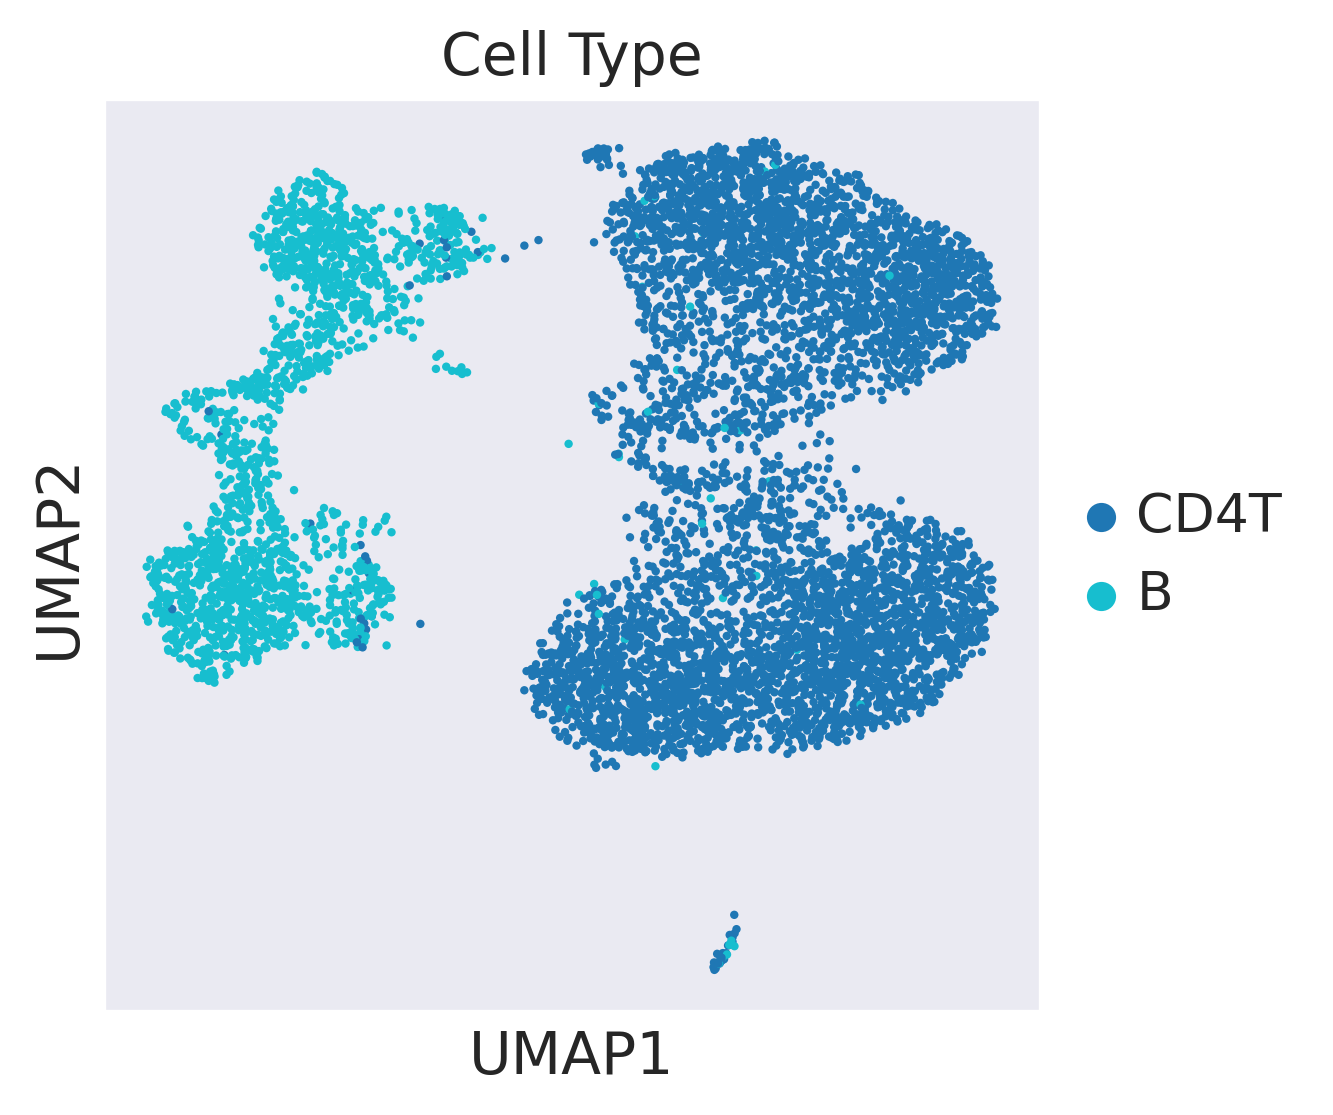

In [21]:
ax = sc.pl.umap(latent_adata, color=['cell_type', 'condition'], frameon=True,palette = "tab10", save ="SF3A1.svg", title = "Cell Type")

/mnt/ufs18/home-091/kanaomar/mambaforge/envs/scVIDR/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


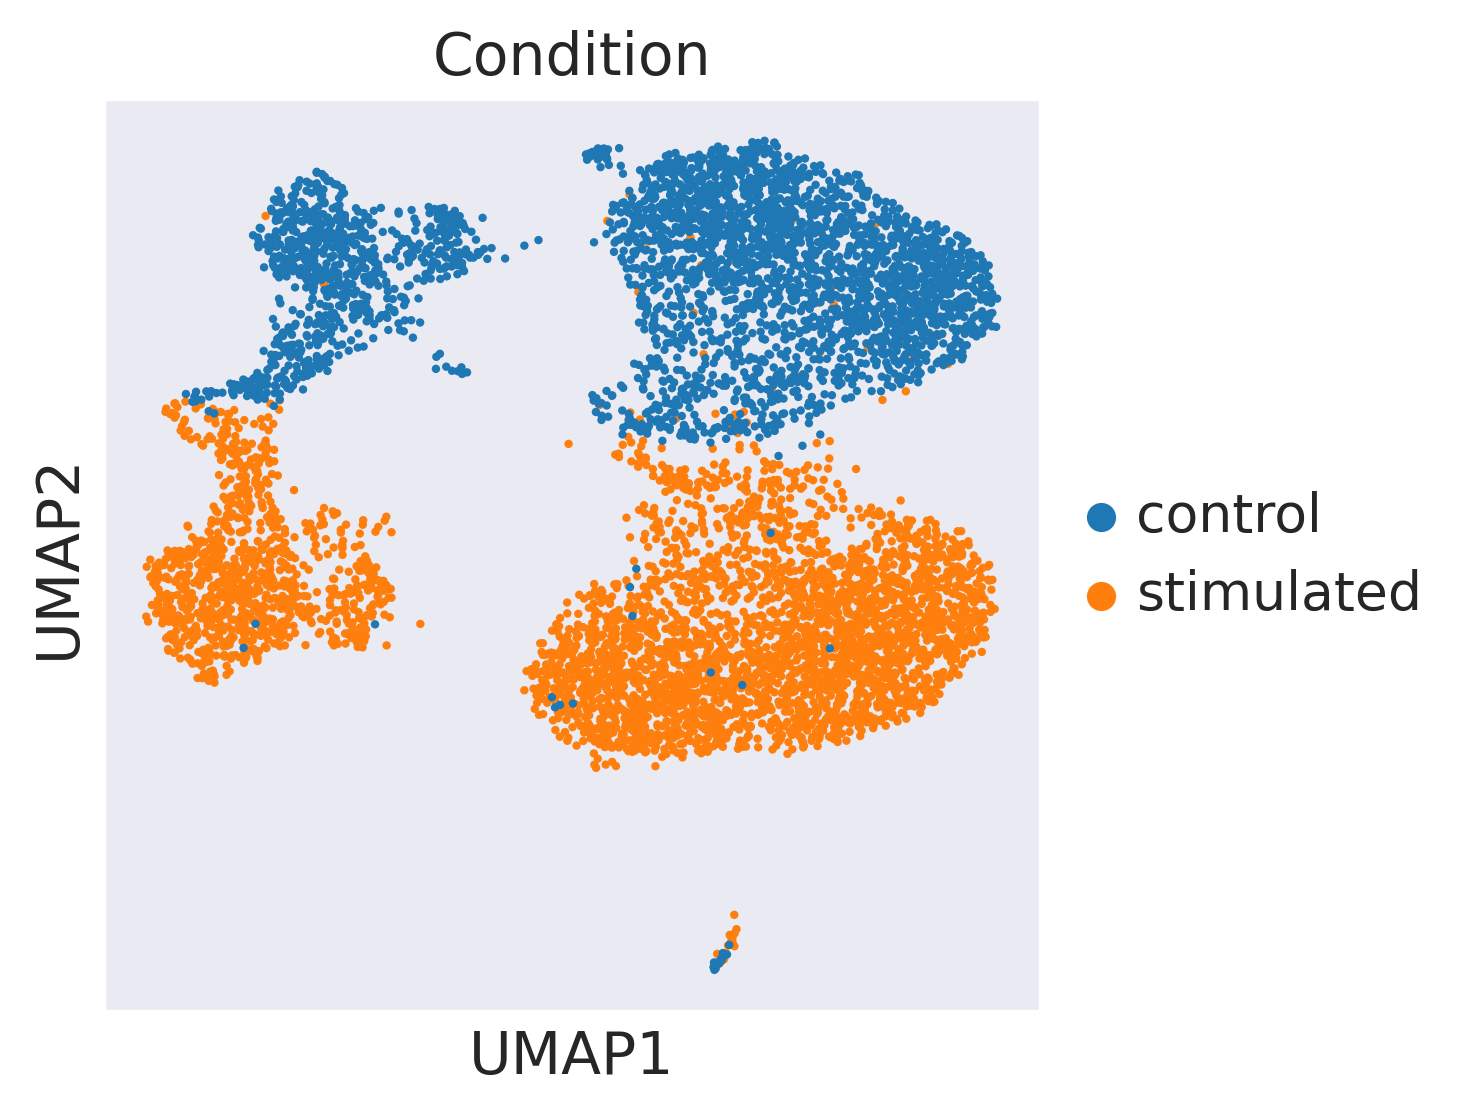

In [22]:
ax = sc.pl.umap(latent_adata, color=['condition'], frameon=True, save ="S3A2.svg", title = "Condition")

/mnt/ufs18/home-091/kanaomar/mambaforge/envs/scVIDR/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


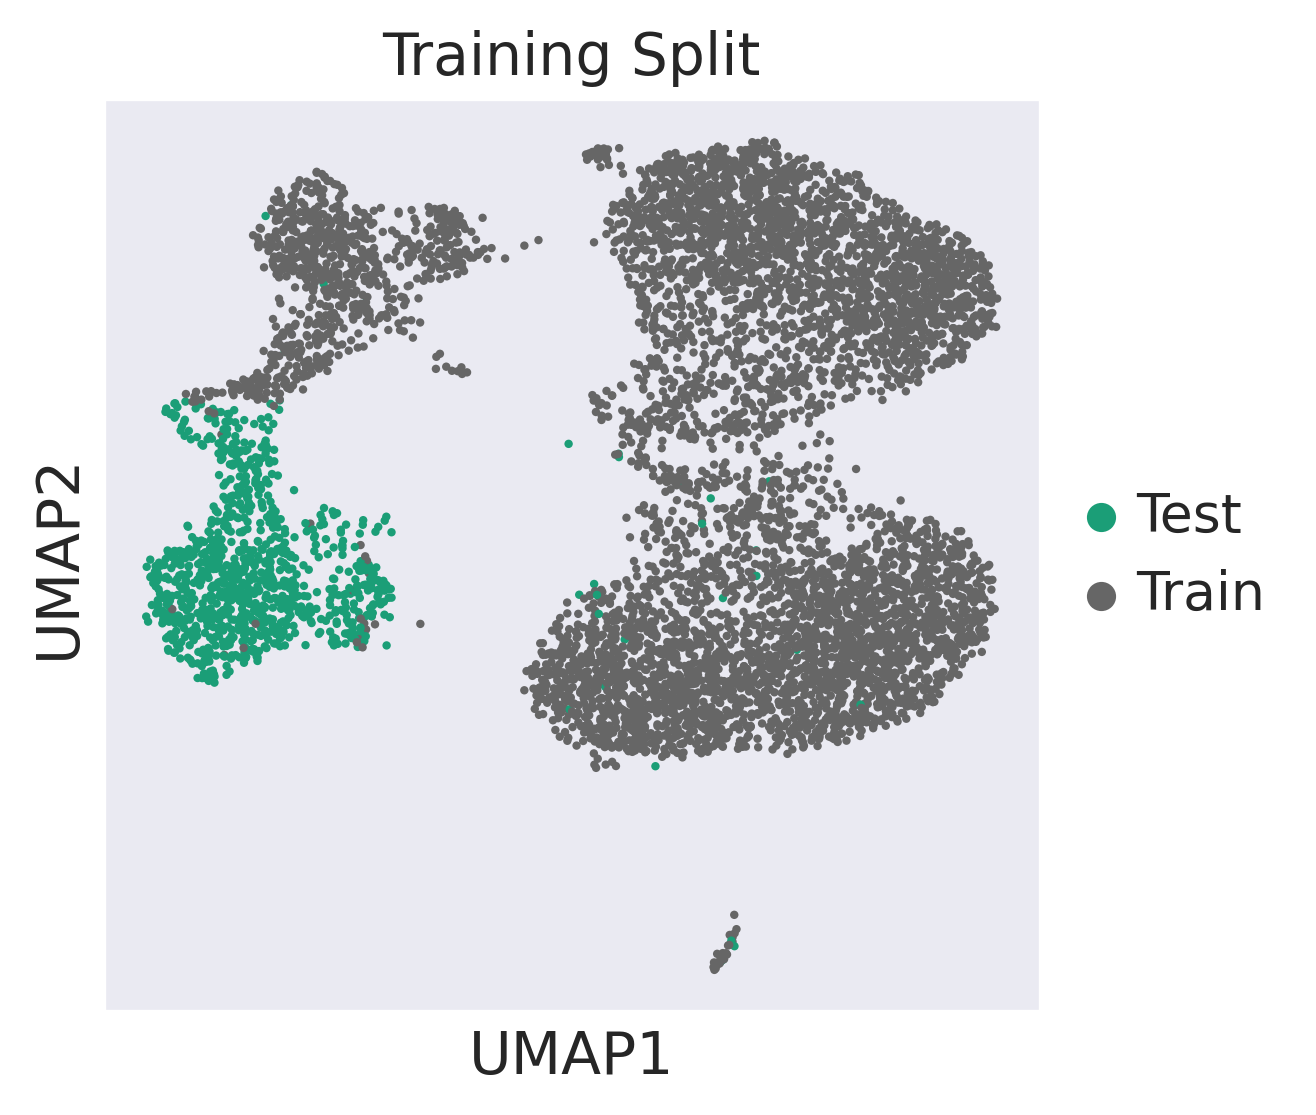

In [23]:
ax = sc.pl.umap(latent_adata, color=['Training Split'], frameon=True,palette="Dark2", save ="S3A3.svg")

# Supplemental Figure 3B

In [7]:
ctrl_key = "control"
treat_key = "stimulated"
cell_type_to_predict = "B"

In [9]:
cell_type_key = model.scvi_setup_dict_["categorical_mappings"]["_scvi_labels"][
    "original_key"
]
treatment_key = model.scvi_setup_dict_["categorical_mappings"]["_scvi_batch"][
    "original_key"
]

In [12]:
ctrl_x = model.adata[model.adata.obs[treatment_key] == ctrl_key]
treat_x = model.adata[model.adata.obs[treatment_key] == treat_key]

In [14]:
#Balancing across treatments 
adata_bal = ctrl_x.concatenate(treat_x)
adata_bal = random_sample(adata_bal, treatment_key, max_or_min = "min", replacement = False)

/mnt/ufs18/home-091/kanaomar/mambaforge/envs/scVIDR/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/mnt/ufs18/home-091/kanaomar/mambaforge/envs/scVIDR/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


In [15]:
#Getting control for validation 
adata_bal_ctrl = adata_bal[(adata_bal.obs[cell_type_key] == cell_type_to_predict) & (adata_bal.obs[treatment_key] == ctrl_key)]

#Getting latent representations
latent_bal =  model.get_latent_representation(adata_bal)
latent_bal_adata = sc.AnnData(X=latent_bal, obs = adata_bal.obs.copy())
latent_cd = latent_bal_adata[(latent_bal_adata.obs[cell_type_key] == cell_type_to_predict) & (latent_bal_adata.obs[treatment_key] == ctrl_key)].X

INFO     Input adata not setup with scvi. attempting to transfer anndata setup                                     
INFO     Using data from adata.X                                                                                   
INFO     Computing library size prior per batch                                                                    
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']                           
INFO     Successfully registered anndata object containing 6254 cells, 6998 vars, 2 batches, 2 labels, and 0       
         proteins. Also registered 0 extra categorical covariates and 0 extra continuous covariates.               


/mnt/ufs18/home-091/kanaomar/mambaforge/envs/scVIDR/lib/python3.8/site-packages/scvi/model/base/_base_model.py:149: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(


In [18]:
#No regression on latent space
ctrl_x = latent_bal_adata[(latent_bal_adata.obs[treatment_key] == ctrl_key) & ~(latent_bal_adata.obs[cell_type_key] == cell_type_to_predict)].X.copy()
treat_x = latent_bal_adata[latent_bal_adata.obs[treatment_key] == treat_key].X.copy()

#Find scGen delta
latent_ctrl = np.average(ctrl_x, axis = 0)
latent_treat = np.average(treat_x, axis = 0)
scgen_delta = latent_treat - latent_ctrl

In [20]:
#Get deltas and control centroids for each cell tpye in the training dataset
deltas = []
latent_centroids = []
cell_types = np.unique(adata_bal.obs[cell_type_key])
for cell_i in cell_types:
    if cell_i != cell_type_to_predict:
        latent_ctrl = latent_bal_adata[(latent_bal_adata.obs[cell_type_key] == cell_i) & (latent_bal_adata.obs[treatment_key] == ctrl_key)].X
        latent_treat = latent_bal_adata[(latent_bal_adata.obs[cell_type_key] == cell_i) & (latent_bal_adata.obs[treatment_key] == treat_key)].X
        deltas_i = np.average(latent_treat, axis = 0) - np.average(latent_ctrl, axis = 0)
        deltas.append(deltas_i)
        latent_centroids.append(np.average(latent_ctrl, axis = 0))
lr = LinearRegression()
reg = lr.fit(latent_centroids, deltas)
scvidr_delta = reg.predict([np.average(latent_cd, axis = 0)])[0]

### scVIDR Results

/mnt/ufs18/home-091/kanaomar/mambaforge/envs/scVIDR/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/mnt/ufs18/home-091/kanaomar/mambaforge/envs/scVIDR/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/mnt/ufs18/home-091/kanaomar/mambaforge/envs/scVIDR/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype be

/mnt/ufs18/home-091/kanaomar/mambaforge/envs/scVIDR/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


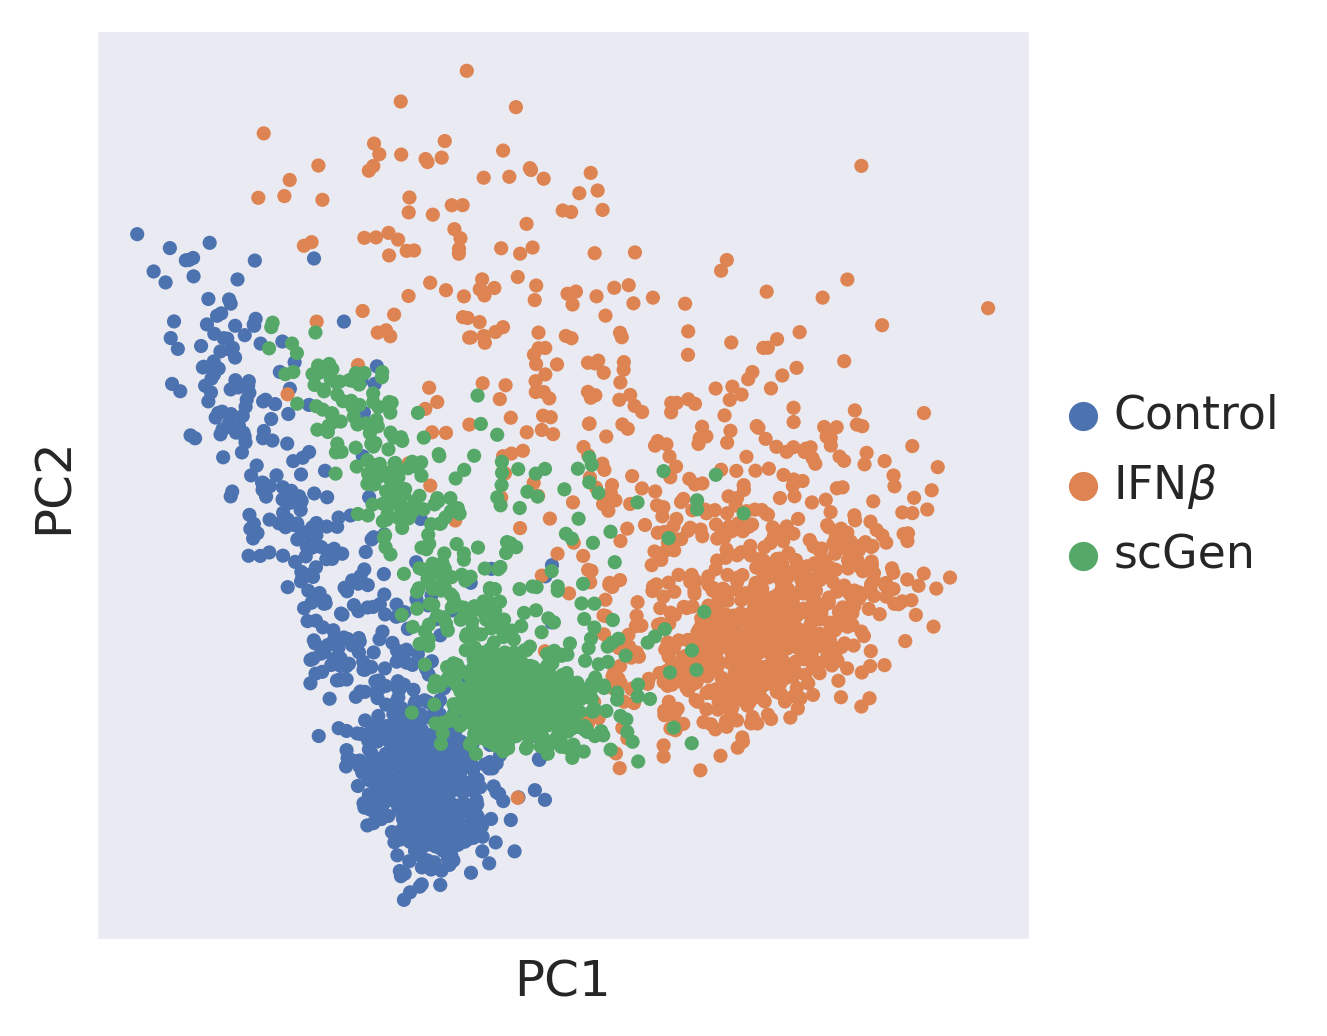

/mnt/ufs18/home-091/kanaomar/mambaforge/envs/scVIDR/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


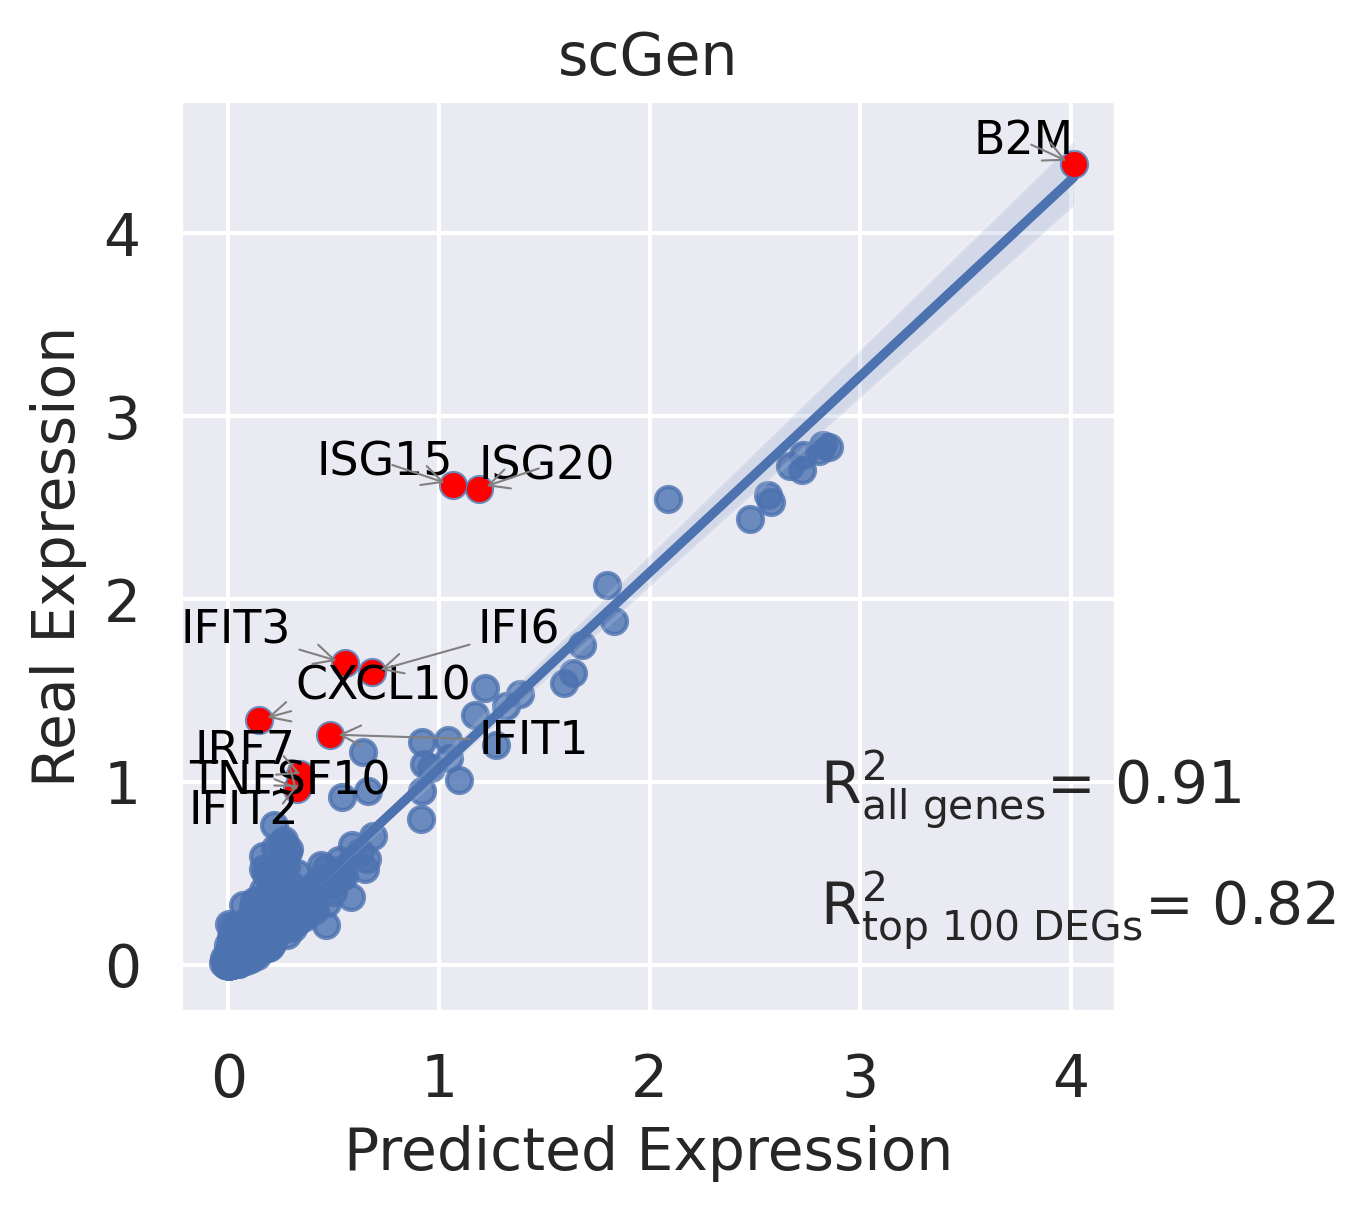

(0.9138199316591675, 0.816085990613895)


In [22]:
#Predict scVIDR results
treat_pred = scgen_delta + latent_cd
predicted_cells = model.module.generative(torch.Tensor(treat_pred))["px"].cpu().detach().numpy()
pred = sc.AnnData(X=predicted_cells , obs=adata_bal_ctrl.obs.copy(), var=adata_bal_ctrl.var.copy(),obsm=adata_bal_ctrl.obsm.copy(),)
pred.obs["condition"] = 'pred'


ctrl_adata = adata[((adata.obs['cell_type'] == cell) & (adata.obs["condition"] == "control"))]
treat_adata = adata[((adata.obs['cell_type'] == cell) & (adata.obs["condition"] == "stimulated"))]
eval_adata1 = ctrl_adata.concatenate(treat_adata, pred)
treatments = []
for i in eval_adata1.obs["condition"]:
    if i == "control":
        treatments.append("Control")
    elif i == "stimulated":
        treatments.append(r"IFN$\beta$")
    else:
        treatments.append("scGen")
eval_adata1.obs["Treatment"] = treatments

#PCA Projection
sc.tl.pca(eval_adata1)
sc.pl.pca(eval_adata1, color = "Treatment", frameon = True, title = "", save = "SF9B.svg")

#Regression Plot
CD4T = adata[adata.obs["cell_type"] ==cell]
sc.tl.rank_genes_groups(CD4T, groupby="condition", method="wilcoxon")
diff_genes = CD4T.uns["rank_genes_groups"]["names"]["stimulated"]
r2_value = model.reg_mean_plot(
eval_adata1,
axis_keys={"x": "pred", "y": r"stimulated"},
gene_list=diff_genes[:10],
top_100_genes = diff_genes[:100],
labels={"x": "Predicted Expression", "y": "Real Expression"},
path_to_save="../figures/SF9C1.svg",
show=True,
legend=False, title = "scGen")
print(r2_value)

/mnt/ufs18/home-091/kanaomar/mambaforge/envs/scVIDR/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/mnt/ufs18/home-091/kanaomar/mambaforge/envs/scVIDR/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/mnt/ufs18/home-091/kanaomar/mambaforge/envs/scVIDR/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype be

/mnt/ufs18/home-091/kanaomar/mambaforge/envs/scVIDR/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


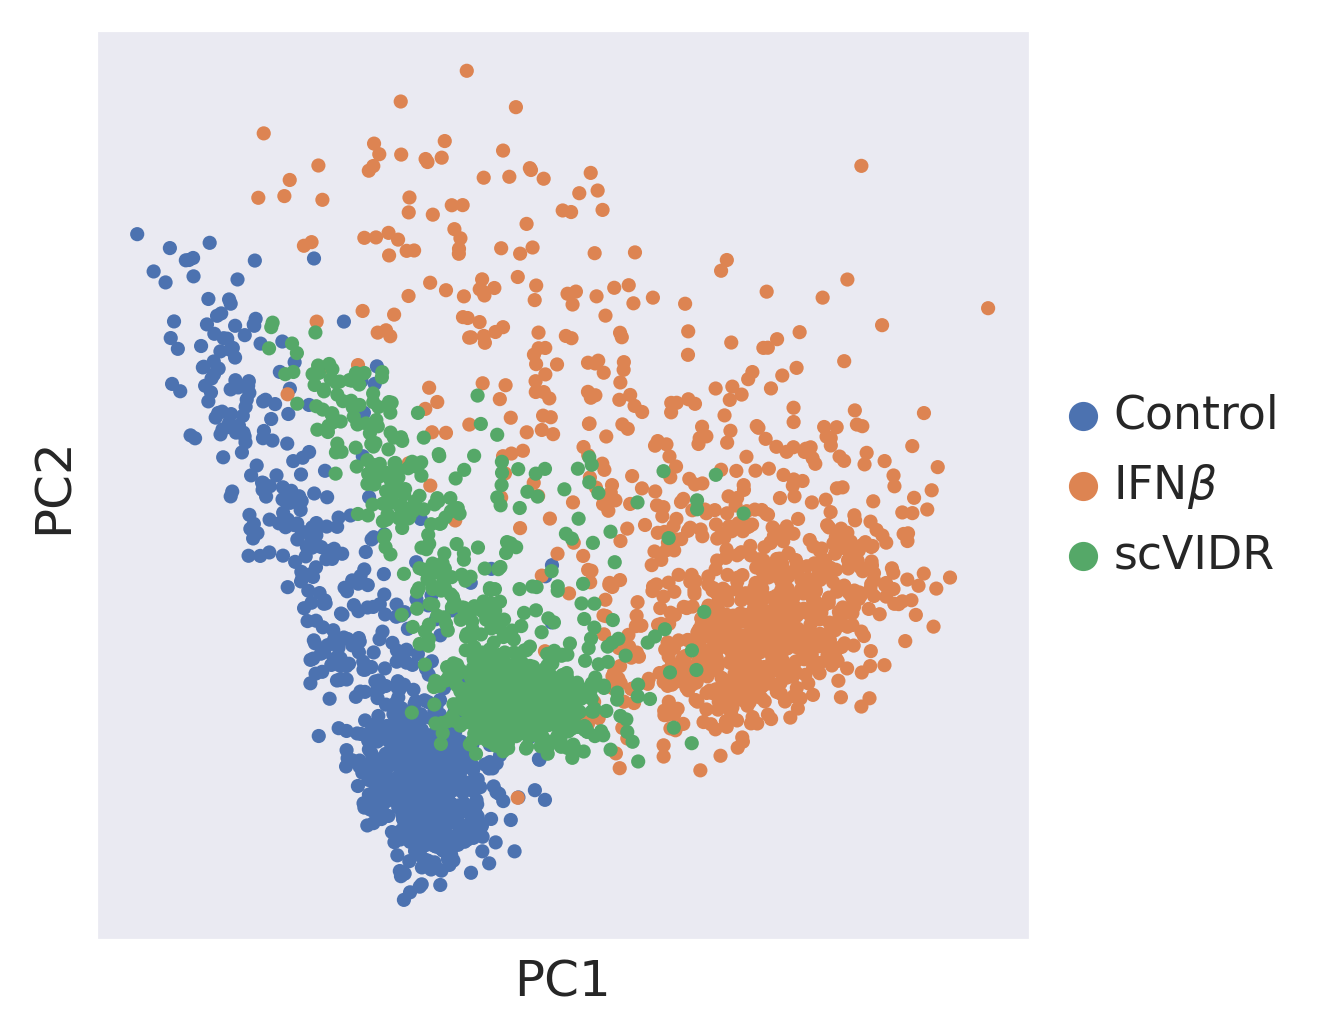

/mnt/ufs18/home-091/kanaomar/mambaforge/envs/scVIDR/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


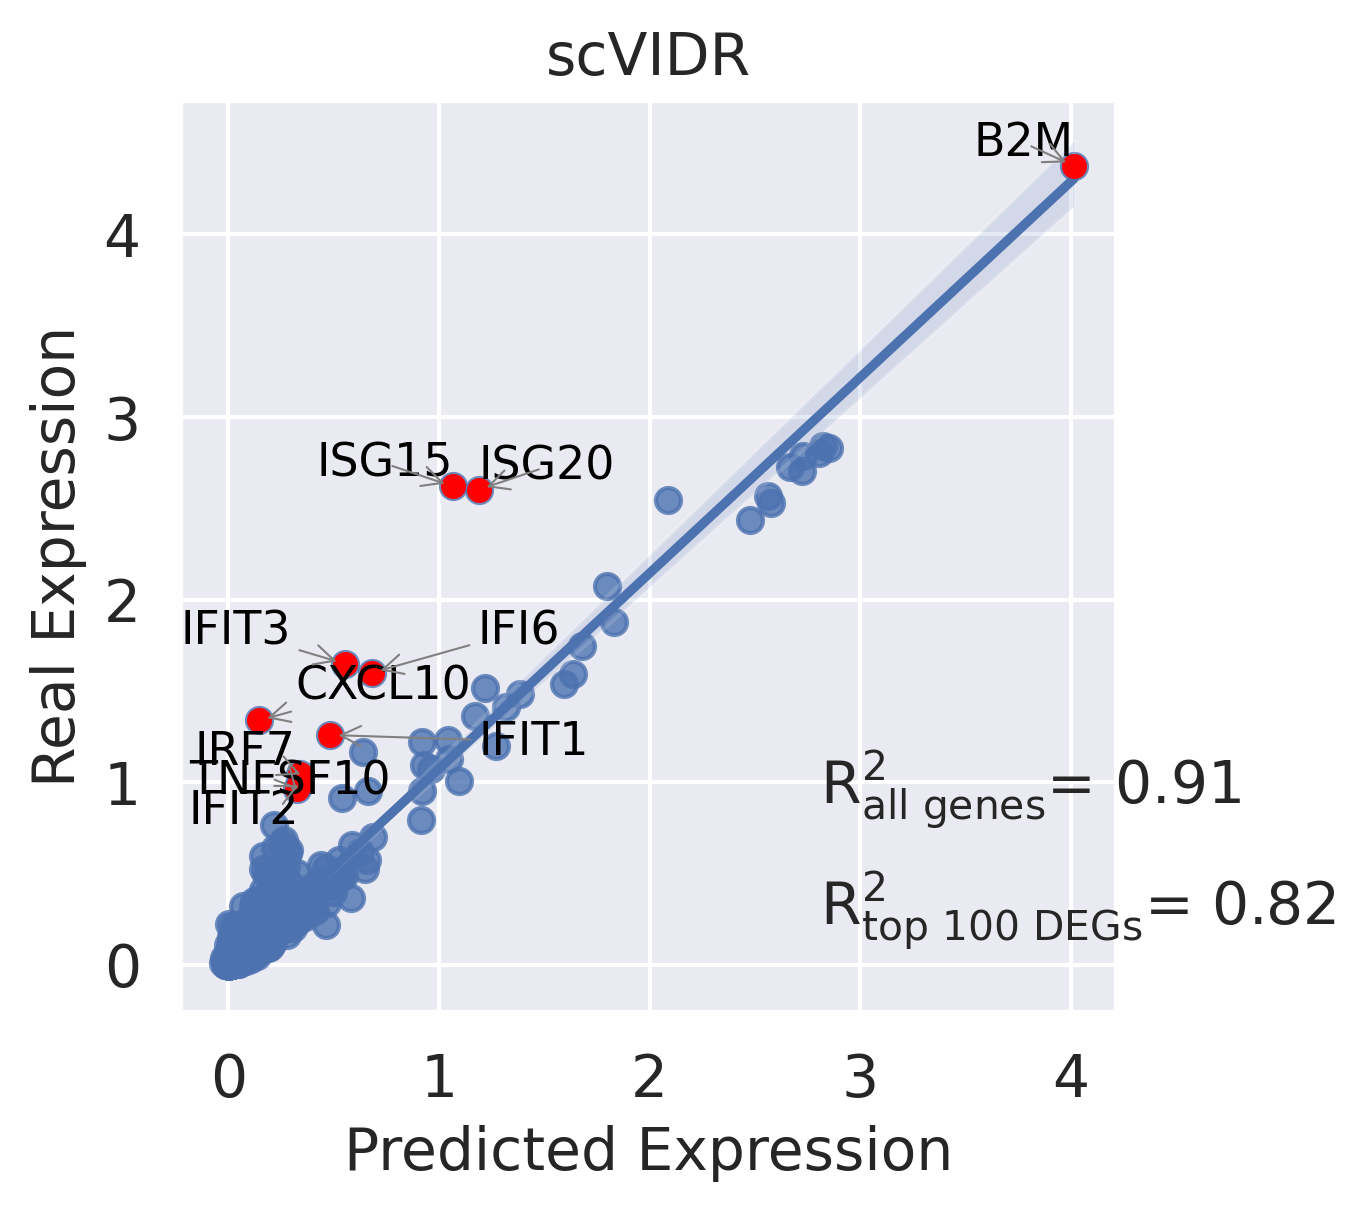

(0.9138199316591675, 0.816085990613895)


In [23]:
#Predict scVIDR results
treat_pred = scvidr_delta + latent_cd
predicted_cells = model.module.generative(torch.Tensor(treat_pred))["px"].cpu().detach().numpy()
pred = sc.AnnData(X=predicted_cells , obs=adata_bal_ctrl.obs.copy(), var=adata_bal_ctrl.var.copy(),obsm=adata_bal_ctrl.obsm.copy(),)

pred.obs["condition"] = 'pred'
ctrl_adata = adata[((adata.obs['cell_type'] == cell) & (adata.obs["condition"] == "control"))]
treat_adata = adata[((adata.obs['cell_type'] == cell) & (adata.obs["condition"] == "stimulated"))]
eval_adata2 = ctrl_adata.concatenate(treat_adata, pred)
treatments = []
for i in eval_adata2.obs["condition"]:
    if i == "control":
        treatments.append("Control")
    elif i == "stimulated":
        treatments.append(r"IFN$\beta$")
    else:
        treatments.append("scVIDR")
eval_adata2.obs["Treatment"] = treatments
sc.tl.pca(eval_adata2)
sc.pl.pca(eval_adata2, color = "Treatment", frameon = True, title = "", save = "sup3C1.svg")
CD4T = adata[adata.obs["cell_type"] ==cell]
sc.tl.rank_genes_groups(CD4T, groupby="condition", method="wilcoxon")
diff_genes = CD4T.uns["rank_genes_groups"]["names"]["stimulated"]
r2_value = model.reg_mean_plot(
eval_adata2,
axis_keys={"x": "pred", "y": r"stimulated"},
gene_list=diff_genes[:10],
top_100_genes = diff_genes[:100],
labels={"x": "Predicted Expression", "y": "Real Expression"},
path_to_save="../figures/S3B2.svg",
show=True,
legend=False, title = "scVIDR")
print(r2_value)

# Supplemental Figure 3C

In [24]:
eval_list  = [eval_adata2[eval_adata2.obs.Treatment == "scVIDR"],
             ]
eval_adata = eval_adata1.concatenate(eval_list)

/mnt/ufs18/home-091/kanaomar/mambaforge/envs/scVIDR/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/mnt/ufs18/home-091/kanaomar/mambaforge/envs/scVIDR/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


/mnt/ufs18/home-091/kanaomar/mambaforge/envs/scVIDR/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


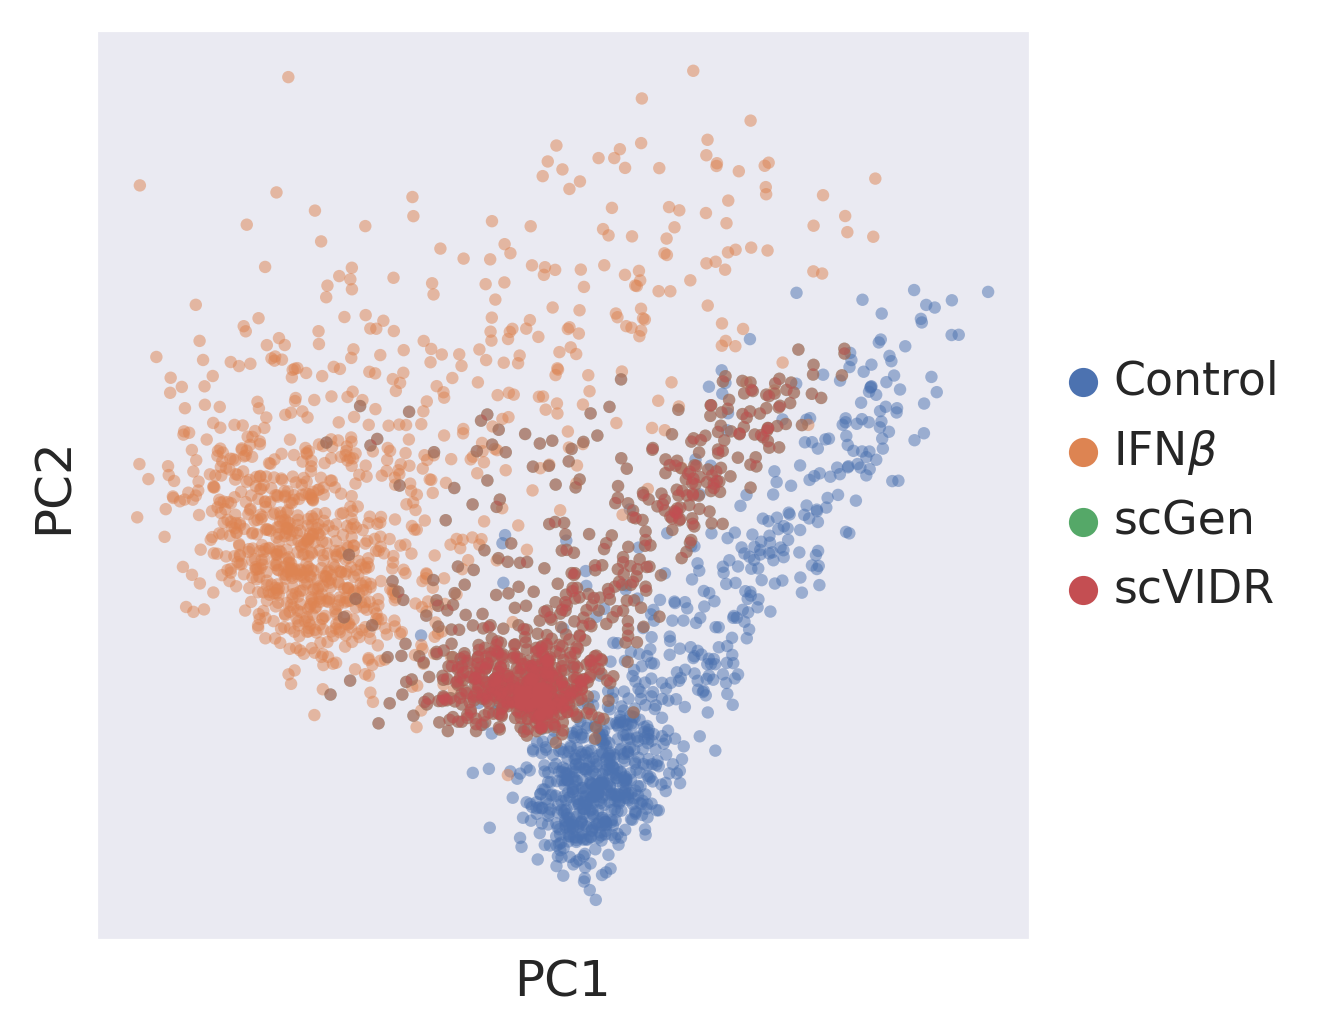

In [27]:
sc.tl.pca(eval_adata)
sc.pl.pca(eval_adata, color = "Treatment", frameon = True, title = "", save = "S3C.svg", alpha = 0.5)